In [5]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
df_meta = pd.read_csv("/home/ec2-user/picassoxbridgedata_coupled/transcriptomics_moa_target 1.csv", index_col = 0)
df_meta.loc[df_meta["Pathway / Target"] == "DMSO", "MoA"] = "DMSO"
df_meta.loc[df_meta["Pathway / Target"] == "DMSO", "Target"] = "DMSO"
#df_meta.columns = [ "Metadata_" + x for x in df_meta.columns]
moa_dict = dict(zip(df_meta["BCS-code"], df_meta["MoA"]))
moa_dict["DMSO"] = "DMSO"
target_dict = dict(zip(df_meta["BCS-code"], df_meta["Target"]))
target_dict["DMSO"] = "DMSO"

In [7]:
wd = "/home/ec2-user/picassoxbridgedata_coupled/s3_multi_omics/merged_transcriptomics_cellpainting/"
readme_train_test = open(f"{wd}train_test_split_details.txt").read()
readme_merged_data_details = open(f"{wd}merged_data_details.txt").read()
transcriptomics_and_meta = f"{wd}features/lyon_transcriptomics_and_meta.csv"
transcriptomics_chemistry_and_meta = (
    f"{wd}features/lyon_transcriptomics_chemistry_and_meta.csv.gz"
)
transcriptomics_variance_filters = f"{wd}features/lyon_transcriptomics_and_meta_variance_filter.csv"
transcriptomics_chemistry_variance_filters = f"{wd}features/lyon_transcriptomics_chemistry_and_meta_variance_filter.csv"
transcriptomics_chemistry_cell_painting_variance_filters = f"{wd}features/lyon_transcriptomics_chemistry_cellpainting_and_meta_variance_filter.csv"
cell_painting_array = f"{wd}features/feats_cp.npy"
combined_metadata = f"{wd}meta/multiomics_combined_metadata.csv"
variane_filter_readme = f"{wd}features/variance_filter_readme.txt"
plot_dir = f"/home/ec2-user/picassoxbridgedata_coupled/s3_multi_omics/multiomics_analyses/concatenated_embedding_plots/"

In [8]:
df_meta = pd.read_csv(combined_metadata, index_col=0)
df_meta.drop_duplicates(["tr_index"], inplace=True)

In [9]:
# df_rna = pd.read_csv(transcriptomics_and_meta, index_col=0)
df_rna_chem = pd.read_csv(transcriptomics_chemistry_and_meta, index_col=0)

# df_rna = df_rna.loc[meta_index.tr_index]
df_rna_chem = df_rna_chem.loc[df_meta.tr_index]

In [10]:
df_rna_chem["METADATA_mode_of_action"] = "Not Available"
df_rna_chem["METADATA_target"] = "Not Available"
df_rna_chem["METADATA_mode_of_action"] = df_rna_chem["METADATA_treatment"].map(moa_dict)
df_rna_chem["METADATA_target"] = df_rna_chem["METADATA_treatment"].map(target_dict)

In [11]:
chem_columns = df_rna_chem.columns[df_rna_chem.columns.str.startswith("CHEM")]
gene_columns = df_rna_chem.columns[df_rna_chem.columns.str.startswith("GE")]
meta_columns = df_rna_chem.columns[df_rna_chem.columns.str.startswith("META")]

In [12]:
import pandas as pd
import matplotlib.pyplot as plt


def plot_variances(df, threshold=0.75):
    # Step 1: Calculate the variance of each column
    variances = df.var()

    # Count columns with zero variance
    zero_variance_columns = variances[variances == 0].index.tolist()
    num_zero_variance = len(zero_variance_columns)

    # Filter out zero variance columns
    variances = variances[variances > 0]

    # Step 2: Plot the histogram of variances
    plt.figure(figsize=(10, 6))
    plt.hist(variances, bins=300, edgecolor="black", alpha=0.7)
    plt.title("Histogram of Column Variances")
    plt.xlabel("Variance")
    plt.ylabel("Frequency")

    # Set x-axis limit to maximum variance
    plt.xlim(0, variances.max() if not variances.empty else 1)

    # Add a vertical line at the threshold
    plt.axvline(x=threshold, color="orange", linestyle="--", label="Threshold (0.75)")

    # Add a line for mean variance
    plt.axvline(x=variances.mean(), color="r", linestyle="--", label="Mean Variance")
    plt.legend()
    plt.show()

    threshold = np.quantile(variances, threshold)
    # Print how many columns would be removed based on the threshold
    columns_to_remove = variances[variances < threshold].index.tolist()
    print(
        "Number of columns to be removed due to variance below threshold:",
        len(columns_to_remove),
    )

    # Print how many columns would be removed due to zero variance
    print("Number of columns to be removed due to zero variance:", num_zero_variance)

    print("Number of columns left: ", len(variances) - len(columns_to_remove))

    reduced_columns = variances[variances >= threshold].index
    return reduced_columns

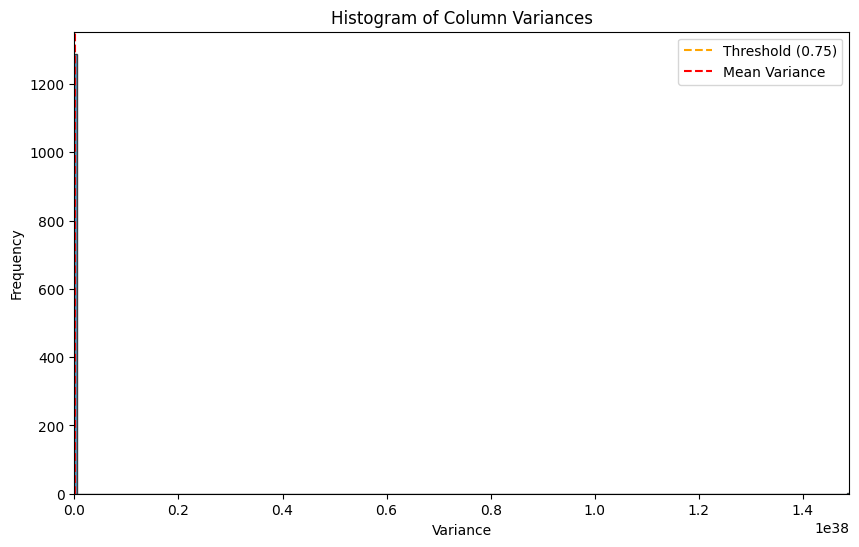

Number of columns to be removed due to variance below threshold: 314
Number of columns to be removed due to zero variance: 111
Number of columns left:  976


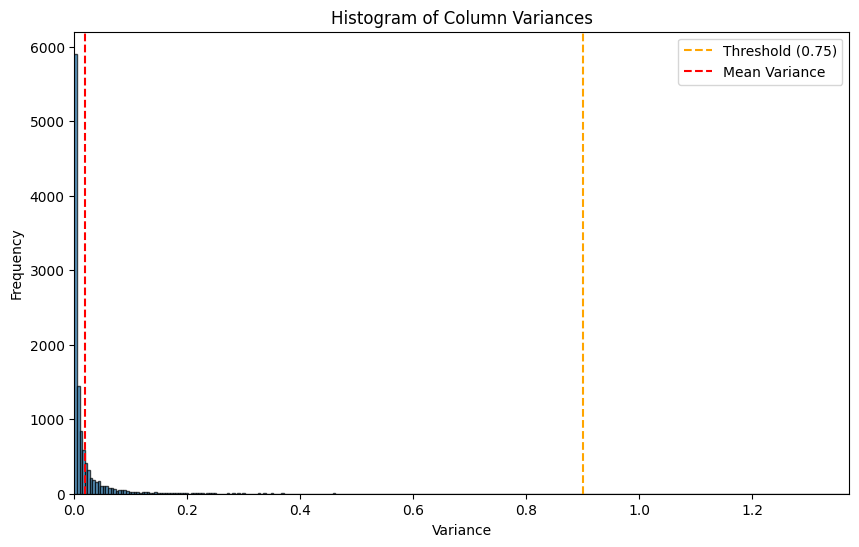

Number of columns to be removed due to variance below threshold: 10289
Number of columns to be removed due to zero variance: 0
Number of columns left:  1144


In [13]:
reduced_chem_columns = plot_variances(df_rna_chem[chem_columns], 0.25)
reduced_gene_columns = plot_variances(df_rna_chem[gene_columns], 0.90)

In [14]:
chem_columns2remove = chem_columns.difference(reduced_chem_columns)
gene_columns2remove = gene_columns.difference(reduced_gene_columns)

In [15]:
print(df_rna_chem.shape)
df_rna_chem.drop(
    columns=chem_columns2remove.to_list() + gene_columns2remove.to_list(), inplace=True
)
print(df_rna_chem.shape)

(667, 12848)
(667, 2134)


In [16]:
chem_columns = df_rna_chem.columns[df_rna_chem.columns.str.startswith("CHEM")].to_list()
gene_columns = df_rna_chem.columns[df_rna_chem.columns.str.startswith("GE")].to_list()
meta_columns = df_rna_chem.columns[df_rna_chem.columns.str.startswith("META")].to_list()

In [17]:
df_rna = df_rna_chem[gene_columns + meta_columns]
df_rna.to_csv(transcriptomics_variance_filters)
df_rna_chem.to_csv(transcriptomics_chemistry_variance_filters)

In [18]:
text_readme = """
The variance filter files are created using this code

 variances = df.var()

# Count columns with zero variance
zero_variance_columns = variances[variances == 0].index.tolist()
num_zero_variance = len(zero_variance_columns)

# Filter out zero variance columns
variances = variances[variances > 0]
threshold = np.quantile(variances, threshold)
columns_to_remove = variances[variances < threshold].index.tolist()

For chemistry
I set the threshold to 0.25. 111 columns were lost due to zero variance and 315 
due to the threshold which leaves 979 columns

For gene expression
I set the threshold to 0.90. 0 columns were lost due to zero variance and 10289
due to the threshold which leaves 1144 columns

I stored the reduced columns in the following files
lyon_transcriptomics_and_meta_variance_filter.csv
lyon_transcriptomics_chemistry_and_meta_variance_filter.csv

I also concatenated the cp columns of all channels and dumped it into
lyon_transcriptomics_chemistry_cellpainting_and_meta_variance_filter.csv

Here the cell painting columns are not reduced in any way and prefixed
with CP_ then the channel. 

In this dataset every modality has around 1000 features which is convenient

This is all based on the version where replicates are randomly match 1 to 1
"""

In [19]:
with open(variane_filter_readme, "w") as f:
    f.write(text_readme)

In [20]:
cp_array = np.load(cell_painting_array)
cp_array_bf = pd.DataFrame(
    cp_array[df_meta.cp_index_bf],
    columns=["CP_bf_" + str(i) for i in range(cp_array.shape[1])],
)
cp_array_nr = pd.DataFrame(
    cp_array[df_meta.cp_index_nr],
    columns=["CP_nr_" + str(i) for i in range(cp_array.shape[1])],
)
cp_array_wga = pd.DataFrame(
    cp_array[df_meta.cp_index_cfw],
    columns=["CP_wga_" + str(i) for i in range(cp_array.shape[1])],
)

In [21]:
combined_df = pd.concat([df_rna_chem.reset_index(drop=True), cp_array_bf.reset_index(drop=True), cp_array_nr.reset_index(drop=True), cp_array_wga.reset_index(drop=True)], axis=1)

cell_painting_columns = combined_df.columns[
    combined_df.columns.str.startswith("CP")
].to_list()
combined_df.dropna(axis = 0, subset=chem_columns + gene_columns + cell_painting_columns, inplace = True)

In [22]:
combined_df.to_csv(transcriptomics_chemistry_cell_painting_variance_filters)

In [23]:
df_meta = combined_df.loc[:, meta_columns]

In [24]:
from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# combined_df[gene_columns + cell_painting_columns] = scaler.fit_transform(
#     combined_df[gene_columns + cell_painting_columns]
# )
combined_df[chem_columns] = combined_df[chem_columns].astype(int)

In [25]:
combined_df.sort_values(["METADATA_mode_of_action", "METADATA_target"], inplace=True)

In [26]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import umap
import itertools
import matplotlib.pyplot as plt

all_combinations = []
for r in range(1, 4):  # r = 1, 2, 3 for different combinations
    all_combinations.extend(
        itertools.combinations(
            [
                ("Chemistry", chem_columns),
                ("RNA", gene_columns),
                ("Cell painting", cell_painting_columns),
            ],
            r,
        )
    )

In [29]:
combined_df.shape

(649, 3286)

/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/anndata

Running PCA and UMAP for data types: Chemistry


/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = 

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

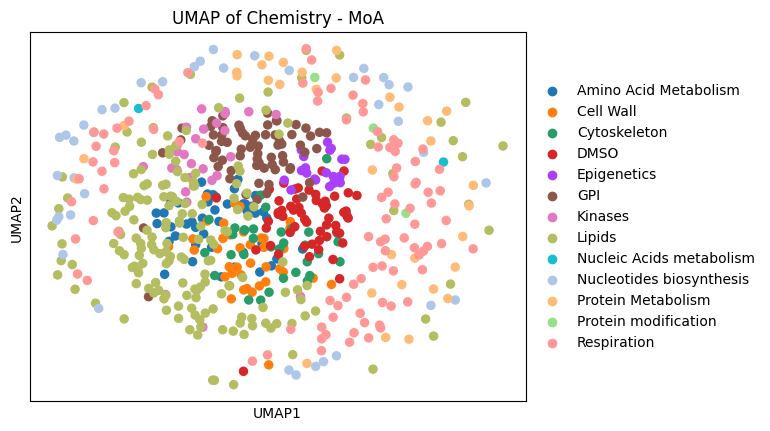

Running PCA and UMAP for data types: RNA


/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = pd.Categorical(values.map(color_map))
/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ec2-user/miniconda3/envs/bridge_env/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:1234: FutureWarning: The d

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

<Figure size 1200x600 with 0 Axes>

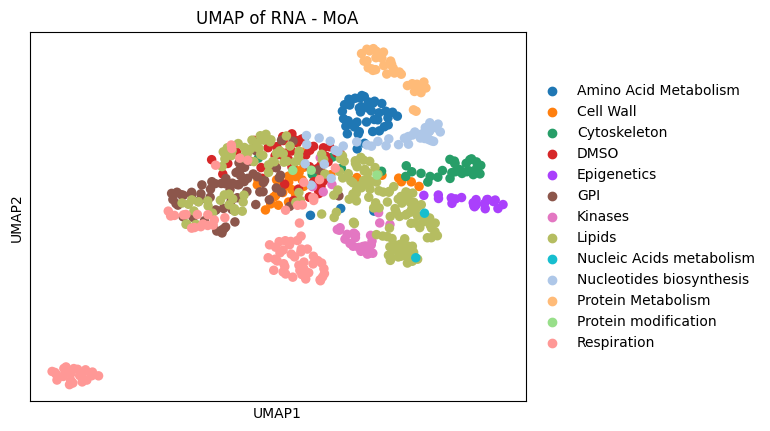

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import umap
import scanpy as sc
import anndata

def run_pca_umap_and_plot(combined_df, df_meta, all_combinations, n_neighbors=15, n_components=2):
    """
    Function to apply PCA followed by UMAP on different combinations of datasets and plot the results.

    Parameters:
    combined_df (pd.DataFrame): The combined dataset containing features.
    df_meta (pd.DataFrame): The metadata containing treatment, target, and MoA information.
    all_combinations (list): List of combinations of column indices to include in UMAP.
    n_neighbors (int): Number of neighbors for UMAP.
    n_components (int): Number of components for PCA.
    """
    for combo in all_combinations:
        # Prepare data types and indices
        data_types = " & ".join([x[0] for x in combo])
        filenames = "_".join([x[0] for x in combo])
        indices = [x[1] for x in combo]
        indices = [item for sublist in indices for item in sublist]
        print(f"Running PCA and UMAP for data types: {data_types}")
        
        # Extract and preprocess data
        data = combined_df[indices + meta_columns].dropna(axis=0).reset_index(drop=True)
        adata = anndata.AnnData(
            X=data[indices], 
            obs=data[meta_columns]
        )
        
        # Step 1: Run PCA
        sc.tl.pca(adata, svd_solver='arpack')
        # Plot UMAP for METADATA_target
        plt.figure(figsize=(12, 6))
        sc.pl.pca(adata, color=["METADATA_target"], show=False)
        plt.title(f"PCA of {data_types} - Target")
        plt.savefig(f"{plot_dir}pca_{filenames}_target.png", bbox_inches='tight')
        plt.close()
        # plt.show()
        
        plt.figure(figsize=(12, 6))
        sc.pl.pca(adata, color=["METADATA_mode_of_action"], show=False)
        plt.title(f"PCA of {data_types} - MoA")
        plt.savefig(f"{plot_dir}pca_{filenames}_moa.png", bbox_inches='tight')
        plt.close()
        # plt.show()
                
        # Step 2: Compute the neighborhood graph
        sc.pp.neighbors(adata, n_neighbors=n_neighbors)

        # Step 3: Run Leiden clustering
        sc.tl.leiden(adata)

        # Step 4: Run PAGA
        sc.tl.paga(adata, groups='leiden')
        sc.pl.paga(adata, plot=False)

        # Step 5: Perform UMAP
        sc.tl.umap(adata, min_dist=0.99, init_pos='paga')

        # Plot UMAP for METADATA_target
        plt.figure(figsize=(12, 6))
        sc.pl.umap(adata, color=["METADATA_target"], show=False)
        plt.title(f"UMAP of {data_types} - Target")
        plt.savefig(f"{plot_dir}umap_{filenames}_target.png", bbox_inches='tight')
        plt.close()
        # plt.show()

        # Plot UMAP for METADATA_mode_of_action
        plt.figure(figsize=(12, 6))
        sc.pl.umap(adata, color=["METADATA_mode_of_action"], show=False)
        plt.title(f"UMAP of {data_types} - MoA")
        plt.savefig(f"{plot_dir}umap_{filenames}_moa.png", bbox_inches='tight')
        plt.show()
        
        plt.close()
# Example of how to call the function
run_pca_umap_and_plot(combined_df, df_meta, all_combinations[:2], n_neighbors=15, n_components=10)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import numpy as np
from joblib import Parallel, delayed
from numba import njit

def create_synthetic_data(X, synthetic_data_type):
    """
    Creates synthetic data for RR dissimilarity.
    
    Parameters:
    X (ndarray): Input data.
    synthetic_data_type (str): Type of synthetic data to create.

    Returns:
    X_total (ndarray): Combined input data and synthetic data.
    Y_total (ndarray): Labels for the combined data.
    """
    nof_objects = X.shape[0]  # Number of observations
    if synthetic_data_type is None:
        synthetic_data_type = 'default'
    
    if synthetic_data_type == 'default':
        synthetic_X = default_synthetic_data(X)
        X_total = np.concatenate([X, synthetic_X])
    elif synthetic_data_type == 'f':
        synthetic_X = f_synthetic_data(X)
        X_total = np.concatenate([np.hstack(X), synthetic_X])
    else:
        print('Bad synthetic data type')
        return -1

    # Create labels for the combined data
    Y_total = np.concatenate([np.zeros(nof_objects), np.ones(nof_objects)])
    return X_total, Y_total

def f_synthetic_data(X_list):
    """
    Creates synthetic data with the same marginal distribution for each feature.

    Parameters:
    X_list (list): List of feature arrays.

    Returns:
    synthetic_X (ndarray): Synthetic data array.
    """
    X = np.hstack(X_list)  # Combine all features into one array
    synthetic_X = np.zeros(X.shape)  # Initialize synthetic data array

    nof_chunks = len(X_list)
    nof_objects = X.shape[0]

    # Randomly select indices for creating synthetic data
    chunks_inds = np.random.choice(np.arange(nof_objects), [nof_objects, nof_chunks])

    for i in range(nof_objects):
        x = [X_list[c][chunks_inds[i, c]] for c in range(nof_chunks)]
        synthetic_X[i] = np.hstack(x)  # Combine selected features

    return synthetic_X

def default_synthetic_data(X):
    """
    Creates synthetic data with the same marginal distribution for each feature.

    Parameters:
    X (ndarray): Input data.

    Returns:
    synthetic_X (ndarray): Synthetic data array.
    """
    synthetic_X = np.zeros(X.shape)  # Initialize synthetic data array

    nof_features = X.shape[1]
    nof_objects = X.shape[0]

    for f in range(nof_features):
        feature_values = X[:, f]  # Get values for the current feature
        synthetic_X[:, f] += np.random.choice(feature_values, nof_objects)  # Randomly select values

    return synthetic_X

class URF(object):
    """
    Unsupervised Random Forest for anomaly detection and distance calculation.
    """

    def __init__(self, n_trees=100, synthetic_data_type=None, max_features='auto', max_depth=None):
        """
        Initializes the URF object with parameters for the random forest.

        Parameters:
        n_trees (int): Number of trees in the random forest.
        synthetic_data_type (str): Type of synthetic data to create.
        max_features (str or int): Number of features to consider when looking for the best split.
        max_depth (int): Maximum depth of the tree.
        """
        self.n_trees = n_trees
        self.synthetic_data_type = synthetic_data_type
        self.max_features = max_features
        self.max_depth = max_depth

    def get_random_forest(self):
        """
        Creates and trains a Random Forest Classifier on synthetic data.

        Returns:
        rf (RandomForestClassifier): Trained random forest model.
        """
        # Generate synthetic data
        X_total, Y_total = create_synthetic_data(self.X, self.synthetic_data_type)

        # Initialize and fit the Random Forest
        rf = RandomForestClassifier(n_jobs=-1, n_estimators=self.n_trees, 
                                    max_features=self.max_features, max_depth=self.max_depth)
        rf.fit(X_total, Y_total)

        return rf

    def get_leafs(self):
        """
        Gets the leaf indices for each observation in the random forest.

        Returns:
        rf_leafs (ndarray): Leaf indices for each tree.
        is_good (ndarray): Matrix indicating which trees classify the observations as 'good'.
        """
        rf = self.get_random_forest()  # Train the random forest
        rf_leafs = rf.apply(self.X)  # Get leaf indices

        is_good = is_good_matrix_get(rf, self.X)  # Get the good tree matrix
        return rf_leafs, is_good

    def get_Xs(self, X):
        """
        Prepares the input data for processing.

        Parameters:
        X (ndarray): Input data to be processed.
        """
        try:
            objnum = X.shape[0]  # Number of observations
            Xs = X  # If X is already an array
        except:
            Xs = X.copy()  # Make a copy if X is not a simple array
            X = np.hstack(Xs)  # Flatten the data
            objnum = X.shape[0]

        # Create feature ranges for parallel processing
        csize = 10
        start = np.arange(1 + int(objnum / csize)) * csize
        end = start + csize
        fe = np.vstack([start, end]).T
        fe[-1][1] = objnum  # Ensure the last range includes all observations

        self.fe = fe
        self.Xs = Xs
        self.X = X

    def get_distance(self, X):
        """
        Computes the distance matrix for the input data.

        Parameters:
        X (ndarray): Input data for which to calculate distances.

        Returns:
        distance_matrix (ndarray): Matrix of distances between observations.
        """
        self.get_Xs(X)  # Prepare the data
        rf_leafs, is_good = self.get_leafs()  # Get leaf indices and good matrix
        # Parallel computation of distance matrix
        distance_matrix = Parallel(n_jobs=-1)(delayed(build_distance_matrix_slow)
                                              (rf_leafs, is_good, se) for se in self.fe)
        distance_matrix = np.vstack(distance_matrix)  # Combine results
        distance_matrix = distance_mat_fill(distance_matrix)  # Fill the distance matrix

        return distance_matrix

    def get_anomaly_score(self, X, mean_over=2500, knn=None):
        """
        Computes anomaly scores for the input data.

        Parameters:
        X (ndarray): Input data for which to calculate anomaly scores.
        mean_over (int): Number of observations to average over for the score.
        knn (int): Number of nearest neighbors to consider for the score.

        Returns:
        anomaly_score (ndarray): Anomaly scores for each observation.
        """
        self.get_Xs(X)  # Prepare the data
        rf_leafs, is_good = self.get_leafs()  # Get leaf indices and good matrix

        nof_objects = X.shape[0]  # Number of observations

        # Adjust mean_over based on the number of objects
        if knn is not None:
            mean_over = nof_objects
            knn = int(knn)

        if mean_over < nof_objects:
            distance_to_objects = np.random.choice(nof_objects, mean_over, replace=False)
        else:
            distance_to_objects = np.arange(nof_objects)

        # Calculate anomaly scores in parallel
        anomaly_score = Parallel(n_jobs=-1)(delayed(get_anomaly_score_slow)
                                              (knn, distance_to_objects, rf_leafs, is_good, se) for se in self.fe)

        anomaly_score = np.concatenate(anomaly_score)  # Combine results

        return anomaly_score

def is_good_vec(tree, X):
    """
    Checks if the predictions from the tree classify the observations as 'good'.

    Parameters:
    tree (DecisionTreeClassifier): A single decision tree from the forest.
    X (ndarray): Input data.

    Returns:
    is_good (ndarray): Boolean array indicating good classifications.
    """
    is_good = (tree.predict_proba(X)[:, 0] > 0.5)  # Classify as 'good' if probability > 0.5
    return is_good

def is_good_matrix_get(forest, X):
    """
    Creates a matrix indicating which trees classify the observations as 'good'.

    Parameters:
    forest (RandomForestClassifier): The trained random forest.
    X (ndarray): Input data.

    Returns:
    is_good_matrix (ndarray): Matrix indicating good classifications from each tree.
    """
    is_good_matrix = Parallel(n_jobs=-1, verbose=0)(delayed(is_good_vec)(tree, X) for tree in forest.estimators_)
    is_good_matrix = np.vstack(is_good_matrix)  # Stack results vertically
    is_good_matrix = is_good_matrix.T  # Transpose for easier access

    return is_good_matrix

@njit
def get_anomaly_score_slow(knn, distance_to_objects, leafs, is_good, fe):
    """
    Calculates the anomaly score for each observation.

    Parameters:
    knn (int): Number of nearest neighbors to consider.
    distance_to_objects (ndarray): Indices of objects to calculate distances to.
    leafs (ndarray): Leaf indices for each observation.
    is_good (ndarray): Matrix indicating which trees classify observations as 'good'.
    fe (ndarray): Feature ranges for parallel processing.

    Returns:
    anomaly_score (ndarray): Anomaly scores for each observation.
    """
    start = fe[0]
    end = fe[1]

    obs_num = leafs.shape[0]
    tree_num = leafs.shape[1]
    anomaly_score = np.zeros(end - start)  # Initialize scores
    dists = np.zeros(distance_to_objects.shape)  # Initialize distance array

    for i in range(start, end):
        for j_idx, j in enumerate(distance_to_objects):
            same_leaf = 0
            good_trees = 0
            for k in range(tree_num):
                if (is_good[i, k] == 1) and (is_good[j, k] == 1):
                    good_trees += 1
                    if (leafs[i, k] == leafs[j, k]):
                        same_leaf += 1
            # Calculate distance based on good trees
            if good_trees == 0:
                dis = 1
            else:
                dis = 1 - float(same_leaf) / good_trees

            dists[j_idx] = dis
        # Calculate anomaly score based on distances
        if knn is None:
            anomaly_score[i - start] = np.sum(dists)
        else:
            anomaly_score[i - start] = np.sort(dists)[knn]

    return anomaly_score

@njit
def build_distance_matrix_slow(leafs, is_good, fe):
    """
    Builds a distance matrix based on leaf indices.

    Parameters:
    leafs (ndarray): Leaf indices for each observation.
    is_good (ndarray): Matrix indicating which trees classify observations as 'good'.
    fe (ndarray): Feature ranges for parallel processing.

    Returns:
    dis_mat (ndarray): Distance matrix.
    """
    start = fe[0]
    end = fe[1]

    obs_num = leafs.shape[0]
    tree_num = leafs.shape[1]
    dis_mat = np.ones((end - start, obs_num))  # Initialize distance matrix

    for i in range(start, end):
        jstart = i
        for j in range(jstart, obs_num):
            same_leaf = 0
            good_trees = 0
            for k in range(tree_num):
                if (is_good[i, k] == 1) and (is_good[j, k] == 1):
                    good_trees += 1
                    if (leafs[i, k] == leafs[j, k]):
                        same_leaf += 1
            # Calculate distance based on good trees
            if good_trees == 0:
                dis = 1
            else:
                dis = 1 - float(same_leaf) / good_trees

            dis_mat[i - start][j] = dis  # Fill the distance matrix

    return dis_mat

@njit
def distance_mat_fill(dis_mat):
    """
    Fills the distance matrix to make it symmetric.

    Parameters:
    dis_mat (ndarray): Distance matrix to be filled.

    Returns:
    dis_mat (ndarray): Symmetric distance matrix.
    """
    for i in range(len(dis_mat)):
        jend = i
        for j in range(0, jend):
            dis_mat[i][j] = dis_mat[j][i]  # Fill in the symmetric values

    return dis_mat  

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap
import numpy as np

def run_pca_umap_and_plot(combined_df, df_meta, all_combinations, meta_columns, plot_dir, n_neighbors=15, n_components=2, min_dist = 0.1):
    """
    Function to apply PCA followed by UMAP on different combinations of datasets and plot the results.

    Parameters:
    combined_df (pd.DataFrame): The combined dataset containing features.
    df_meta (pd.DataFrame): The metadata containing treatment, target, and MoA information.
    all_combinations (list): List of combinations of column indices to include in UMAP.
    meta_columns (list): List of metadata columns.
    plot_dir (str): Directory to save the plots.
    n_neighbors (int): Number of neighbors for UMAP.
    n_components (int): Number of components for PCA.
    """
    for combo in all_combinations:
        # Prepare data types and indices
        data_types = " & ".join([x[0] for x in combo])
        filenames = "_".join([x[0] for x in combo])
        indices = [x[1] for x in combo]
        indices = [item for sublist in indices for item in sublist]
        print(f"Running PCA and UMAP for data types: {data_types}")
        
        # Extract and preprocess data
        data = combined_df[indices + meta_columns].dropna(axis=0).reset_index(drop=True)
        features = data[indices]
        meta_data = data[meta_columns]
        
        # Step 0: Compute the distance matrix using URF
        urf_model = URF(n_trees=100, max_features=None, max_depth=None)
        distance_matrix = urf_model.get_distance(features.values)
        
        # Step 1: Run PCA on the distance matrix
        # Note: PCA is typically run on the feature space, not on a distance matrix.
        # If you want to visualize the distance matrix, consider using UMAP directly.
        pca = PCA(n_components=n_components)
        pca_result = pca.fit_transform(distance_matrix)
        
        pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(n_components)])
        pca_df = pd.concat([pca_df, meta_data.reset_index(drop=True)], axis=1)
        
        # Plot PCA results
        plt.figure(figsize=(8, 8))
        ax = plt.gca()
        sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='METADATA_target', palette='tab10', ax=ax)
        plt.title(f"PCA of {data_types} - Target")
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
        plt.savefig(f"{plot_dir}pca_{filenames}_from_rf_target.png", bbox_inches='tight')
        # plt.show()
        plt.close()
        
        plt.figure(figsize=(8, 8))
        ax = plt.gca()
        sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='METADATA_mode_of_action', palette='tab10', ax=ax)
        plt.title(f"PCA of {data_types} - MoA")
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
        plt.savefig(f"{plot_dir}pca_{filenames}_from_rf_moa.png", bbox_inches='tight')

        # plt.show()
        plt.close()
        
        # Step 3: Run UMAP on the distance matrix
        reducer = umap.UMAP(
            n_neighbors=n_neighbors,
            metric='precomputed',  # Use the precomputed distance matrix
            min_dist = min_dist
        )
        umap_result = reducer.fit_transform(distance_matrix)
        
        umap_df = pd.DataFrame(data=umap_result, columns=['UMAP1', 'UMAP2'])
        umap_df = pd.concat([umap_df, meta_data.reset_index(drop=True)], axis=1)
        umap_df.sort_values("METADATA_target", inplace=True)
        
        # Plot UMAP results
        plt.figure(figsize=(8, 8))
        ax = plt.gca()
        sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='METADATA_target', palette='tab10', ax=ax)
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
        plt.title(f"UMAP of {data_types} - Target")
        plt.savefig(f"{plot_dir}umap_{filenames}_from_rf_target.png", bbox_inches='tight')
        # plt.show()
        plt.close()
        
        plt.figure(figsize=(8, 8))
        ax = plt.gca()
        sns.scatterplot(data=umap_df, x='UMAP1', y='UMAP2', hue='METADATA_mode_of_action', palette='tab10', ax=ax)
        plt.title(f"UMAP of {data_types} - MoA")
        plt.savefig(f"{plot_dir}umap_{filenames}_from_rf_moa.png", bbox_inches='tight')
        sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

        # plt.show()
        plt.close()

In [ ]:
# Example usage
# combined_df, df_meta, and all_combinations should be defined as per your data
run_pca_umap_and_plot(
    combined_df,
    df_meta,
    all_combinations,
    meta_columns,
    plot_dir,
    n_neighbors=50,
    n_components=2,
    min_dist = 0.5
)